In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, fbeta_score, make_scorer, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import shap

In [14]:
df = pd.read_csv("/content/drive/MyDrive/PS-Ligia_Time16/risco_cardiovascular_features.csv")

In [15]:
# Codificação do Target (Separação Features e Target)

le = LabelEncoder()
y = le.fit_transform(df["BP_Category"])
X = df.drop("BP_Category", axis=1)

df.drop("HighRisk", axis=1)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,BP_Category,Sleep_Efficiency,Cardiac_Stress_Index
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,Normal,36.6,462
1,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,37.2,600
2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,37.2,600
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Stage1,23.6,680
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Stage1,23.6,680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,Stage1,72.9,204
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,Stage1,72.0,204
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,Stage1,72.9,204
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,Stage1,72.9,204


In [16]:
# Divisão dos conjuntos para Treino e Teste (80/20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# Tratamento de Dados

bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]

## Separando features em tipos de dados e transformações necessárias

num_features = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]
ord_features = ["BMI Category"]
nom_features = ["Gender", "Occupation"]

preprocessor = ColumnTransformer(transformers=[
    ("numeric", StandardScaler(), num_features),
    ("ordinal", OrdinalEncoder(categories=[bmi_order]), ord_features),
    ("nominal", OneHotEncoder(handle_unknown="ignore"), nom_features)
])

In [18]:
# Estruturação do Pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)), # Define quanto da variância explicada original será mantida para no treinamento
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

In [19]:
#F2-Score (Atribui peso dobrado ao Recall em relação a Precisão)

f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [20]:
# Estruturação dos parâmetros para o GridSearch

param_grid = {
    'xgb__n_estimators': [50, 100, 200], # Quantidade de árvores
    'xgb__max_depth': [3, 4, 5],         # Profundidade (baixa para evitar decorar)
    'xgb__learning_rate': [0.01, 0.1],   # Velocidade de aprendizado
    'xgb__gamma': [0, 0.1, 0.2],         # Custo para criar novos nós (poda)
    'pca__n_components': [5, 7, 9]       # Quantos componentes manter
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=f2_scorer, n_jobs=-1)

In [21]:
# GridSearch encontra a configuração do melhor modelo

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Sleep '
                                                                          'Duration',
                                                                          'Quality '
                                                                          'of '
                                                                          'Sleep',
                                                                          'Physical '
                                                                          'Activity '
                                                                          'Level',
                                                                          'Stress '
                                                                          'Level',
                                                                          'Heart '
                                                                          'Rate',
                                                                          'Daily '
                                                                          'Steps']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(categories=[['Underweight',
                                                                                                     'Normal '
                                                                                                     'Weight',
                                                                                                     'Overweight',
                                                                                                     'Obese']]),
                                                                         ['BMI '
                                                                          'Category...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 7, 9],
                         'xgb__gamma': [0, 0.1, 0.2],
                         'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__n_estimators': [50, 100, 200]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, average=weighted))

In [22]:
# Avaliação do modelo

print(f"\n---RELATÓRIO DE CLASSIFICAÇÃO---")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# 1. Relatório por classe
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 2. Média de amostragem de todas as classes (AUC-ROC)
auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
print(f"\nAUC-ROC Global: {auc_score:.4f}")

# 3. F2-Score
f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
print(f"\nF2-Score Decisivo: {f2:.4f}")

# 4. Melhores Hiperparâmetros encontrados
print("\nMelhores parâmetros:", grid_search.best_params_)


---RELATÓRIO DE CLASSIFICAÇÃO---
              precision    recall  f1-score   support

    Elevated       0.96      1.00      0.98        22
      Normal       1.00      0.94      0.97        33
      Stage1       0.95      1.00      0.98        20

    accuracy                           0.97        75
   macro avg       0.97      0.98      0.97        75
weighted avg       0.97      0.97      0.97        75


AUC-ROC Global: 0.9862

F2-Score Decisivo: 0.9731

Melhores parâmetros: {'pca__n_components': 9, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 200}


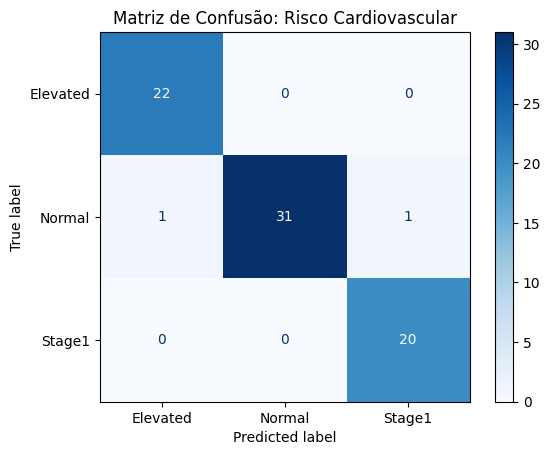

In [23]:
# Matriz de Confusão (Visualização da precisão e recall do modelo)

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão: Risco Cardiovascular')
plt.show()

### Visualização das features com SHAP

In [27]:
# Parâmetros do XGBoost encontrados pelo GridSearch
params_clean = {k.replace('xgb__', ''): v for k, v in grid_search.best_params_.items() if k.startswith('xgb__')}

# Aqui repetimos o modelo anterior criado com esses parâmetros, mas sem o PCA
xgb_inspecao = XGBClassifier(**params_clean, use_label_encoder=False, eval_metric='mlogloss')

preprocessor.fit(X_train)

X_train_preprocessed = preprocessor.transform(X_train)
xgb_inspecao.fit(X_train_preprocessed, y_train)

# Nomes das colunas reais (após One-Hot e Ordinal)
feature_names = preprocessor.get_feature_names_out()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


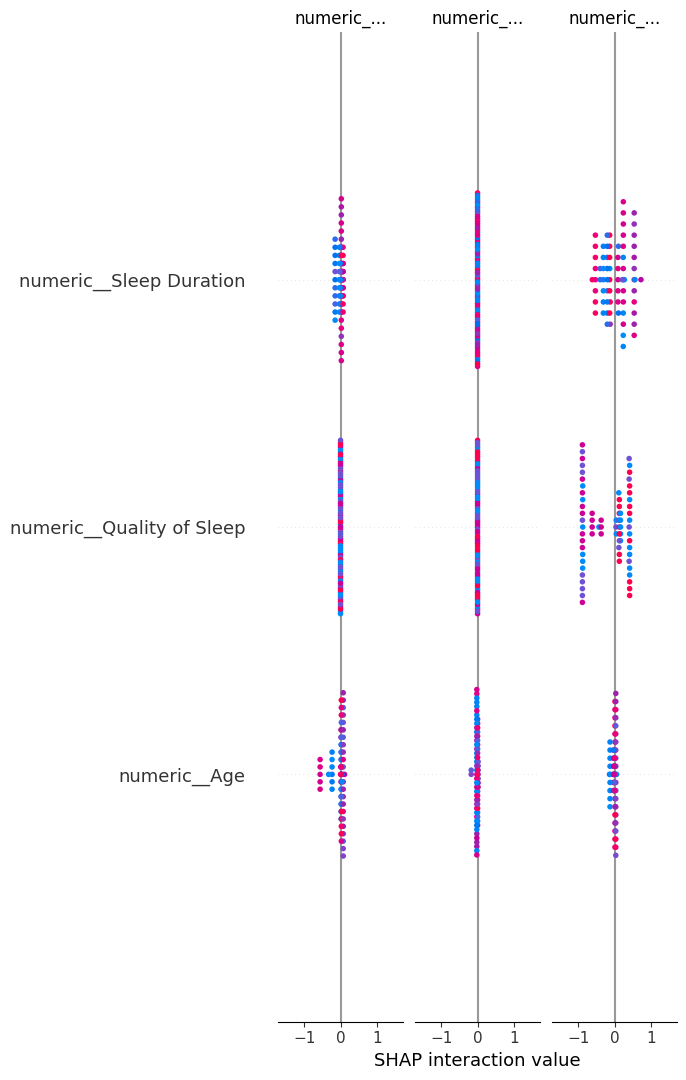

In [31]:
# Display

X_test_preprocessed = preprocessor.transform(X_test)
explainer_direto = shap.TreeExplainer(xgb_inspecao)
shap_values_direto = explainer_direto.shap_values(X_test_preprocessed)

shap.summary_plot(shap_values_direto, X_test_preprocessed, feature_names=feature_names)